In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import BlackScholes as bs
import time
import variance_curve as vc
import ImpliedDrift as iD

from rbergomi import rBergomi
from matplotlib import cm

In [2]:
def price(S, K, r, q, T):
    n = len(K)
    p = np.zeros(n)
    for i in range(n):
        p[i] = np.mean(np.maximum(S-K[i],0)*np.exp(-(r-q)*T))
    return p

In [3]:
dates = np.array(["23_01_23.csv", "24_01_23.csv", "25_01_23.csv", "26_01_23.csv", "27_01_23.csv",
                  "30_01_23.csv", "06_02_23.csv", "13_02_23.csv", "21_02_23.csv"])

spot = np.array(pd.read_csv("spot.csv").Spot).flatten()

moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])

data = pd.read_csv(dates[0])
maturities = np.array(data['Exp Date']).flatten()
IV = np.array(data.drop(columns = 'Exp Date'))/100.

param = np.array(pd.read_csv("rB_stability_parameters.csv"))

Text(0.5, 1.0, 'H')

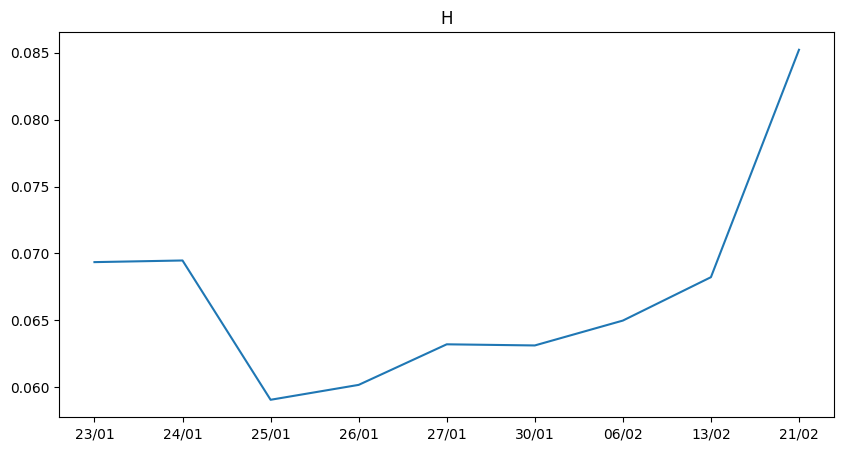

In [13]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

days = np.array(["23/01", "24/01", "25/01", "26/01", "27/01", "30/01", "06/02", "13/02", "21/02"])
plt.plot(days, param[:,0])
plt.title("H")

Text(0.5, 1.0, 'Eta')

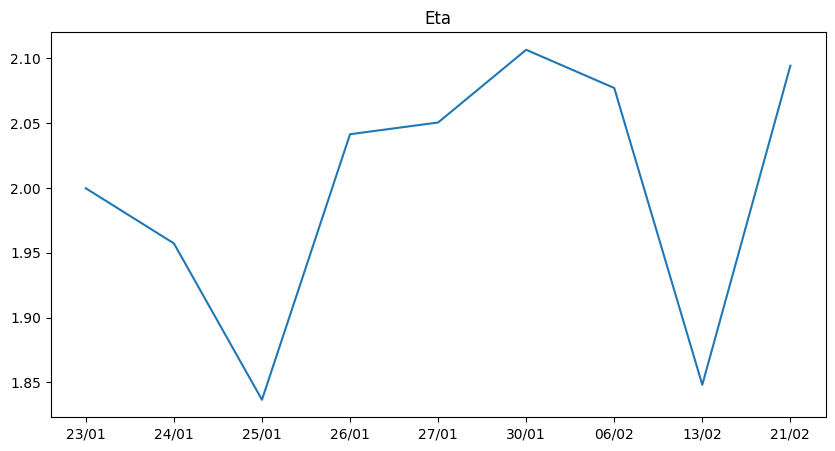

In [16]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

plt.plot(days, param[:,1])
plt.title("Eta")

Text(0.5, 1.0, 'Rho')

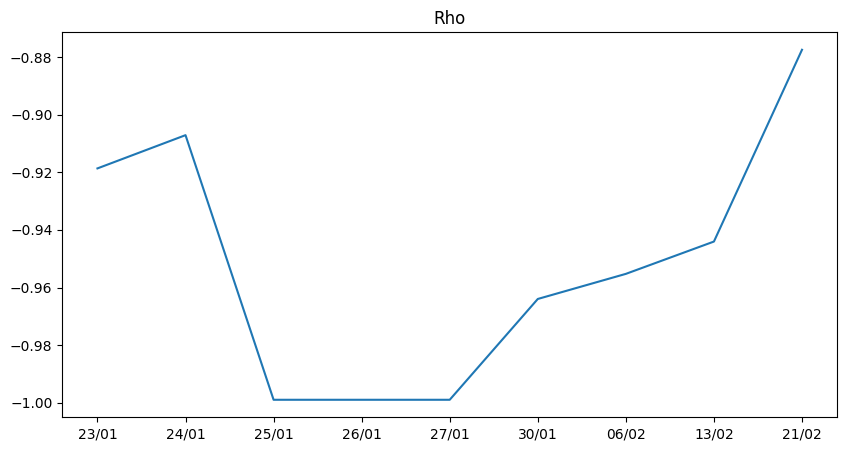

In [17]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

plt.plot(days, param[:,2])
plt.title("Rho")

In [9]:
nr = len(maturities); nc = len(dates);
rB_err = np.zeros(nc-1)
N = 20000; n = 365;
H, eta, rho = param[0]
alpha = H - 0.5

for i in range(1, nc):
    
    start_time = time.time()
    
    data = pd.read_csv(dates[i])
    maturities = np.array(data['Tenor']).flatten()
    IV = np.array(data.drop(columns = ['Date','Tenor']))/100.
    
    S0 = spot[i]
    K = moneyness*S0/100

    steps = np.ceil(n*maturities).astype(int)
    T = maturities[-1]
    np.random.seed(0)
    
    index = i
    iv = np.zeros([nr,nc])
    r = iD.r(maturities, index); q = iD.q(maturities, index);

    rB = rBergomi(n, N, T, alpha)
    xi = vc.variance_curve(rB.t[0], index)
    dW1 = rB.dW1(); dW2 = rB.dW2();    
    Ya = rB.Y(dW1)
    dZ = rB.dZ(dW1, dW2, rho)
    V = rB.V(Ya, xi, eta)

    S = rB.global_S(V, dZ, S0, steps, index)

    for j in range(nr):
        P = price(S[j], K, r[j], q[j], maturities[j])
        iv[j] = bs.BSImpliedVol(S0, K, maturities[j], r[j], q[j], P, Option_type = 1, toll = 1e-5)

    total_time = (time.time() - start_time)/60

    print(f'Execution time: {time.time()-start_time: .2f} s')

    rB_err[i-1] = np.mean(abs(IV-iv)/IV)*100

    print(f"Relative mean error: {rB_err[i-1]:.4f}%\n")

Execution time:  115.24 s
Relative mean error: 3.7907%

Execution time:  114.93 s
Relative mean error: 7.5450%

Execution time:  143.47 s
Relative mean error: 4.0075%

Execution time:  138.40 s
Relative mean error: 3.3171%

Execution time:  129.75 s
Relative mean error: 4.6345%

Execution time:  118.48 s
Relative mean error: 2.2557%

Execution time:  148.10 s
Relative mean error: 8.6483%

Execution time:  134.86 s
Relative mean error: 3.8043%



Text(0.5, 1.0, 'Mean percentage error')

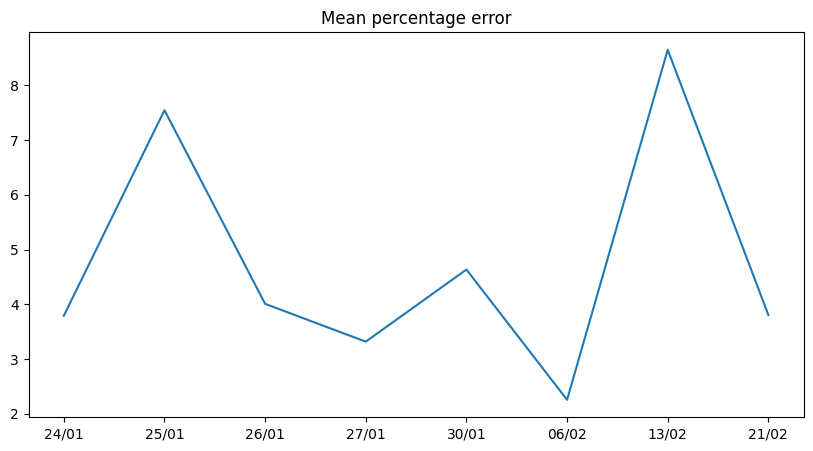

In [12]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

days = np.array(["24/01", "25/01", "26/01", "27/01", "30/01", "06/02", "13/02", "21/02"])
plt.plot(days, rB_err)
plt.title("Mean percentage error")

In [23]:
std = param.std(axis = 0); var = param.var(axis = 0);
title = np.array(["H", "Eta", "Rho"])
for i in range(3):
    print(f"{title[i]}:\tStandard deviation ={std[i]: .4f}\tVariance ={var[i]: .4f}\n")

H:	Standard deviation = 0.0074	Variance = 0.0001

Eta:	Standard deviation = 0.0955	Variance = 0.0091

Rho:	Standard deviation = 0.0415	Variance = 0.0017



In [24]:
var

array([5.42400282e-05, 9.12134947e-03, 1.72606747e-03])

In [25]:
param.round(4)

array([[ 0.0694,  1.9998, -0.9186],
       [ 0.0695,  1.9573, -0.9071],
       [ 0.0591,  1.8366, -0.999 ],
       [ 0.0602,  2.0415, -0.999 ],
       [ 0.0632,  2.0506, -0.999 ],
       [ 0.0631,  2.1067, -0.964 ],
       [ 0.065 ,  2.0772, -0.9553],
       [ 0.0682,  1.8482, -0.944 ],
       [ 0.0852,  2.0944, -0.8774]])

In [28]:
benchmark = np.array([3.5448, 5.9528, 3.3960, 3.0902, 4.6805, 2.1697, 7.8451, 2.8109])

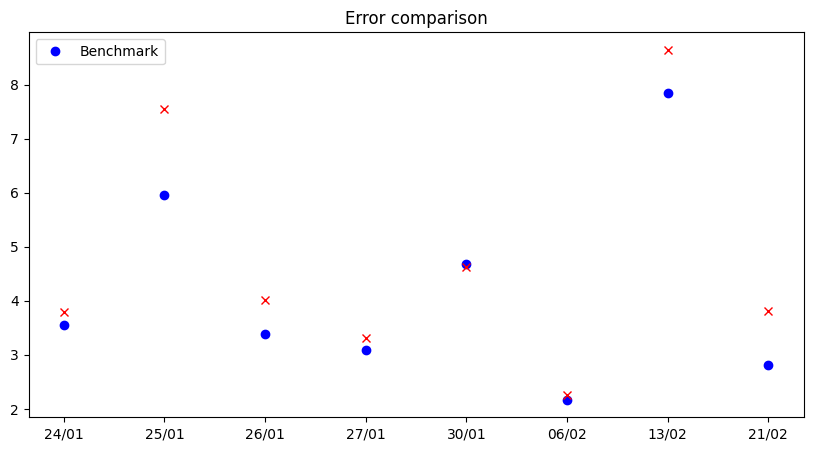

In [30]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

plt.plot(days, benchmark, 'bo')
plt.plot(days, rB_err.round(4), 'rx')
plt.title("Error comparison")
plt.legend(["Benchmark"])